# Clouds over SGP for April 4, 2019

Looking at LASSO data for April 4, 2019 to see meterological data and calculate cloud base and cloud top.

---

## Imports


In [4]:
from datetime import datetime
import numpy as np
import xarray as xr
import fsspec
import xwrf

import matplotlib.pyplot as plt

## Bring in the data

Here is the raw model output from LASSO.

In [7]:
# Set the URL and path for the cloud
URL = 'https://js2.jetstream-cloud.org:8001/'
path = f'pythia/lasso-sgp'

# Configure the s3-like storage endpoint on jetstream
fs = fsspec.filesystem("s3", anon=True, client_kwargs=dict(endpoint_url=URL))

# Set the analysis date and simulation number
case_date = datetime(2019, 4, 4)
sim_id = 7

# Read the wrfstat files
wrfstat_pattern = f's3://{path}/sim000{sim_id}/raw_model/wrfstat*'
wrfstat_files = sorted(fs.glob(wrfstat_pattern))

# Remotely read these into a list
wrfstat_file_list = [fs.open(file) for file in wrfstat_files]
wrfstat_file_list

### Load into an `xarray.Dataset`

In [31]:
ds_stat = xr.open_mfdataset(wrfstat_file_list, engine='h5netcdf')

# Rename time - in this case, we are not using xwrf to clean the dataset
ds_stat["Time"] = ds_stat["XTIME"]
ds_stat

<xarray.Dataset> Size: 72GB
Dimensions:         (Time: 91, bottom_top: 226, bottom_top_stag: 227,
                     south_north: 250, west_east: 250, west_east_stag: 251,
                     south_north_stag: 251)
Coordinates:
    XTIME           (Time) datetime64[ns] 728B dask.array<chunksize=(91,), meta=np.ndarray>
  * Time            (Time) datetime64[ns] 728B 2019-04-04T12:00:00 ... 2019-0...
Dimensions without coordinates: bottom_top, bottom_top_stag, south_north,
                                west_east, west_east_stag, south_north_stag
Data variables: (12/179)
    Times           (Time) |S19 2kB dask.array<chunksize=(1,), meta=np.ndarray>
    CST_CLDLOW      (Time) float32 364B dask.array<chunksize=(91,), meta=np.ndarray>
    CST_CLDTOT      (Time) float32 364B dask.array<chunksize=(91,), meta=np.ndarray>
    CST_LWP         (Time) float32 364B dask.array<chunksize=(91,), meta=np.ndarray>
    CST_IWP         (Time) float32 364B dask.array<chunksize=(91,), meta=np.ndarray>
    CST_PRECW       (Time) float32 364B dask.array<chunksize=(91,), meta=np.ndarray>
    ...              ...
    CSV_IWC         (Time, bottom_top, south_north, west_east) float32 5GB dask.array<chunksize=(1, 226, 125, 125), meta=np.ndarray>
    CSV_CLDFRAC     (Time, bottom_top, south_north, west_east) float32 5GB dask.array<chunksize=(1, 226, 125, 125), meta=np.ndarray>
    CSS_LWP         (Time, south_north, west_east) float32 23MB dask.array<chunksize=(1, 125, 125), meta=np.ndarray>
    CSS_IWP         (Time, south_north, west_east) float32 23MB dask.array<chunksize=(1, 125, 125), meta=np.ndarray>
    CSS_CLDTOT      (Time, south_north, west_east) float32 23MB dask.array<chunksize=(1, 125, 125), meta=np.ndarray>
    CSS_CLDLOW      (Time, south_north, west_east) float32 23MB dask.array<chunksize=(1, 125, 125), meta=np.ndarray>
Attributes: (12/96)
    TITLE:                                  OUTPUT FROM WRF V3.8.1 MODEL
    START_DATE:                            2019-04-04_12:00:00
    WEST-EAST_GRID_DIMENSION:              251
    SOUTH-NORTH_GRID_DIMENSION:            251
    BOTTOM-TOP_GRID_DIMENSION:             227
    DX:                                    100.0
    ...                                    ...
    config_aerosol:                        NA
    config_forecast_time:                  15.0 h
    config_boundary_method:                Periodic
    config_microphysics:                   Thompson (mp_physics=8)
    config_nickname:                       runlas20190404v1msda2d150km
    simulation_origin_host:                cumulus-login2.ccs.ornl.gov

## Find the indices of the boundary layer depth - in case we happen to care about that later

In [32]:
ds_stat["bottom_top"] = ds_stat.bottom_top
ds_stat
ki = ds_stat['CSP_THL'].idxmin(dim='bottom_top')
ki.load()

<xarray.DataArray 'bottom_top' (Time: 91)> Size: 728B
array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  1.,
        2.,  2.,  2.,  3.,  3.,  3.,  2.,  2.,  2.,  3.,  3.,  3.,  4.,
        4.,  4.,  5.,  5.,  5.,  5.,  5.,  6.,  6.,  7.,  7.,  7.,  7.,
        8., 10., 12., 13., 13., 12., 12., 12., 11., 11., 11., 10., 11.,
       11., 11., 10., 11., 10., 10., 10., 10., 10., 10., 10.,  9.,  9.,
        9.,  9.,  8.,  8.,  7.,  7.,  6.,  6.,  4.,  3.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])
Coordinates:
    XTIME    (Time) datetime64[ns] 728B 2019-04-04T12:00:00 ... 2019-04-05T03...
  * Time     (Time) datetime64[ns] 728B 2019-04-04T12:00:00 ... 2019-04-05T03...

## Let's look at some meteorological info for this date

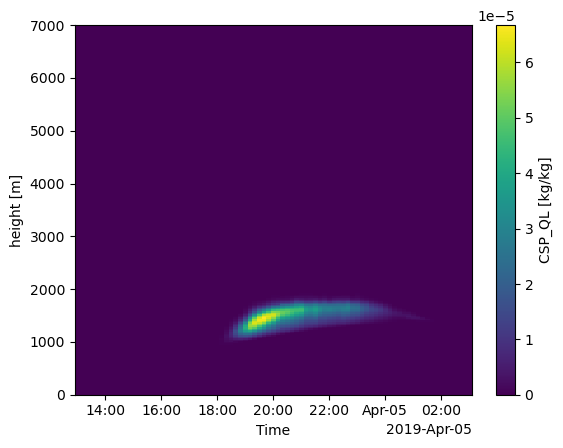

In [33]:
plot_ql = ds_stat['CSP_QL'].assign_coords(height = (ds_stat["CSP_Z"]))
plot_ql.isel(Time=slice(6,None)).plot(x = 'Time',y = 'height', ylim=[0,7000])

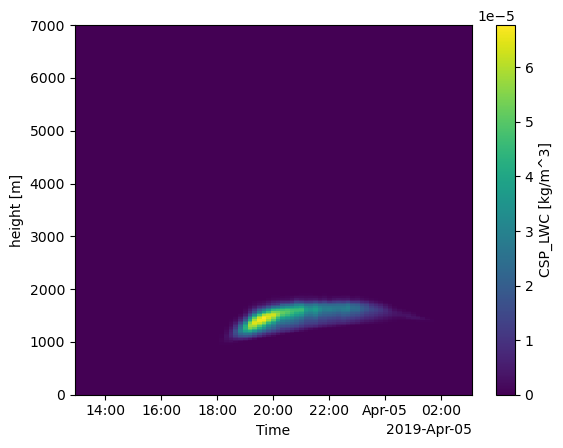

In [34]:
plot_lwc = ds_stat['CSP_LWC'].assign_coords(height = (ds_stat["CSP_Z"]))
plot_lwc.isel(Time=slice(6,None)).plot(x = 'Time',y = 'height', ylim=[0,7000])

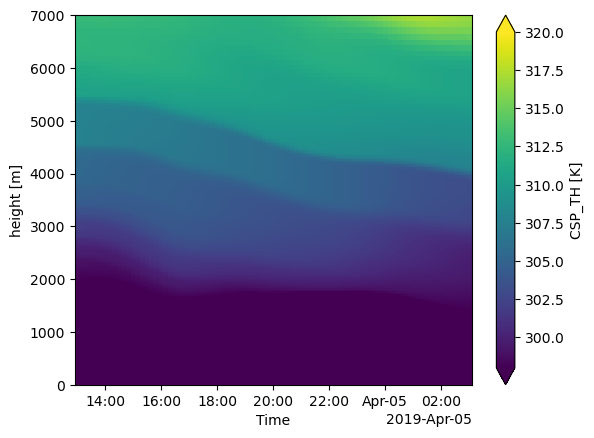

In [35]:
plot_thl = ds_stat['CSP_TH'].assign_coords(height = (ds_stat["CSP_Z"]))
plot_thl.isel(Time=slice(6,None)).plot(x = 'Time',y = 'height', ylim=[0,7000],vmin=298,vmax=320)

# Fix some height things so that we can plot...

The z values are time dependent, so we need to deal with the height values by assuming that the first time step is close enough

We also need to make bottom_top a coordinate so that we aren't yelled at by errors

In [36]:
ds_stat["bottom_top"] = ds_stat.bottom_top

In [37]:
ds_stat['bottom_top'] = ds_stat['CSP_Z'].isel(Time = 1).values

In [38]:
ds_stat['bottom_top'].values # make sure that these are heights and not indicies

array([   15.215184,    45.605114,    75.94632 ,   106.27506 ,
         136.59618 ,   166.91183 ,   197.23079 ,   227.55254 ,
         257.86115 ,   288.1541  ,   318.44684 ,   348.74237 ,
         379.03595 ,   409.33054 ,   439.62314 ,   469.91293 ,
         500.20493 ,   530.4964  ,   560.79016 ,   591.11    ,
         621.4132  ,   651.6837  ,   681.9462  ,   712.2066  ,
         742.4813  ,   772.7549  ,   803.0155  ,   833.27167 ,
         863.53253 ,   893.79333 ,   924.05646 ,   954.3343  ,
         984.625   ,  1014.9191  ,  1045.2263  ,  1075.5452  ,
        1105.8611  ,  1136.1669  ,  1166.4724  ,  1196.7739  ,
        1227.061   ,  1257.3391  ,  1287.613   ,  1317.8835  ,
        1348.1545  ,  1378.427   ,  1408.7014  ,  1438.9777  ,
        1469.2583  ,  1499.5316  ,  1529.7927  ,  1560.058   ,
        1590.3406  ,  1620.6185  ,  1650.8711  ,  1681.1194  ,
        1711.373   ,  1741.6282  ,  1771.863   ,  1802.084   ,
        1832.3059  ,  1862.5199  ,  1892.7288  ,  1922.

# Calculate cloud base and top from the liquid water conent and the liquid water mixing ratio


In [39]:
ds_stat['cb_lwc'] = (ds_stat['CSP_LWC']>0).idxmax(dim = 'bottom_top')
ds_stat['cb_lwc'] = ds_stat['cb_lwc'].where(ds_stat['cb_lwc']>ds_stat['bottom_top'][0])
print(ds_stat['cb_lwc'])

ds_stat['ct_lwc'] = ((ds_stat['CSP_LWC'].isel(bottom_top = slice(None, None, -1)))>0).idxmax(dim='bottom_top')
ds_stat['ct_lwc'] = ds_stat['ct_lwc'].where(ds_stat['ct_lwc']<ds_stat['bottom_top'][-1])
print(ds_stat['ct_lwc'])

<xarray.DataArray 'cb_lwc' (Time: 91)> Size: 364B
dask.array<where, shape=(91,), dtype=float32, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
    XTIME    (Time) datetime64[ns] 728B dask.array<chunksize=(91,), meta=np.ndarray>
  * Time     (Time) datetime64[ns] 728B 2019-04-04T12:00:00 ... 2019-04-05T03...
<xarray.DataArray 'ct_lwc' (Time: 91)> Size: 364B
dask.array<where, shape=(91,), dtype=float32, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
    XTIME    (Time) datetime64[ns] 728B dask.array<chunksize=(91,), meta=np.ndarray>
  * Time     (Time) datetime64[ns] 728B 2019-04-04T12:00:00 ... 2019-04-05T03...


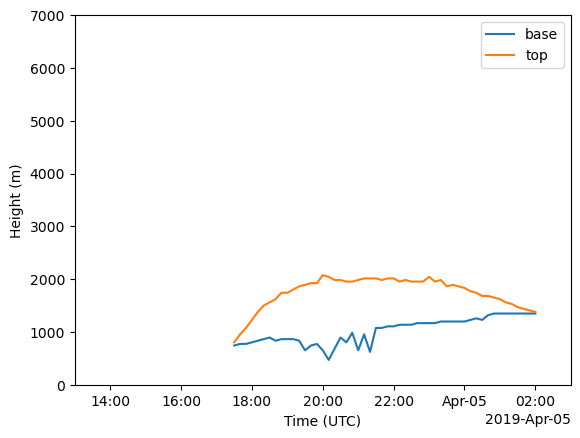

In [40]:
ds_stat['cb_lwc'].plot(label='base',ylim = (0,7000),xlim = (ds_stat['CSP_Z'].Time[6],ds_stat['CSP_Z'].Time[-1]))
ds_stat['ct_lwc'].plot(label='top',ylim = (0,7000),xlim = (ds_stat['CSP_Z'].Time[6],ds_stat['CSP_Z'].Time[-1]))
plt.legend()
plt.ylabel('Height (m)')
plt.xlabel('Time (UTC)')
plt.show()

In [41]:
ds_stat['cb_ql'] = (ds_stat['CSP_LWC']>0).idxmax(dim = 'bottom_top')
ds_stat['cb_ql'] = ds_stat['cb_ql'].where(ds_stat['cb_ql']>ds_stat['bottom_top'][0])
print(ds_stat['cb_ql'].load())

ds_stat['ct_ql'] = ((ds_stat['CSP_LWC'].isel(bottom_top = slice(None, None, -1)))>0).idxmax(dim='bottom_top')
ds_stat['ct_ql'] = ds_stat['ct_ql'].where(ds_stat['ct_ql']<ds_stat['bottom_top'][-1])
print(ds_stat['ct_ql'].load())

<xarray.DataArray 'cb_ql' (Time: 91)> Size: 364B
array([       nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,  742.4813 ,  772.7549 ,
        772.7549 ,  803.0155 ,  833.27167,  863.53253,  893.79333,
        833.27167,  863.53253,  863.53253,  863.53253,  833.27167,
        651.6837 ,  742.4813 ,  772.7549 ,  651.6837 ,  469.91293,
        681.9462 ,  893.79333,  803.0155 ,  984.625  ,  651.6837 ,
        954.3343 ,  621.4132 , 1075.5452 , 1075.5452 , 1105.8611 ,
       1105.8611 , 1136.1669 , 1136.1669 , 1136.1669 , 1166.4724 ,
       1166.4724 , 1166.4724 , 1166.4724 , 1196.7739 , 1196.7739 ,
       1196.7

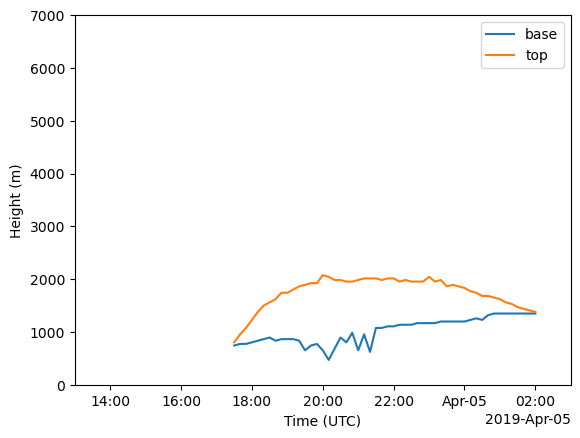

In [42]:
ds_stat['cb_ql'].plot(label='base',ylim = (0,7000),xlim = (ds_stat['CSP_Z'].Time[6],ds_stat['CSP_Z'].Time[-1]))
ds_stat['ct_ql'].plot(label='top',ylim = (0,7000),xlim = (ds_stat['CSP_Z'].Time[6],ds_stat['CSP_Z'].Time[-1]))
plt.legend()
plt.ylabel('Height (m)')
plt.xlabel('Time (UTC)')
plt.show()

## Conclusions
We notice how similar the cloud base/top are at their beginning and end times! This framework enables a streamlined method of analyzing clouds within the simulation data, including derived quantities such as cloud base/height.